In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# Novelty and Outlier Detection

Many applications require being able to decide whether a new observation
belongs to the same distribution as existing observations (it is an
*inlier*), or should be considered as different (it is an *outlier*).
Often, this ability is used to clean real data sets. Two important
distinctions must be made:

* outlier detection
>    The training data contains outliers which are defined as
>    observations that are far from the others. Outlier detection
>    estimators thus try to fit the regions where the training data is
>    the most concentrated, ignoring the deviant observations.

* novelty detection
>   The training data is not polluted by outliers and we are interested
>   in detecting whether a **new** observation is an outlier. In this
>   context an outlier is also called a novelty.

Outlier detection and novelty detection are both used for anomaly
detection, where one is interested in detecting abnormal or unusual
observations. Outlier detection is then also known as unsupervised
anomaly detection and novelty detection as semi-supervised anomaly
detection. In the context of outlier detection, the outliers/anomalies
cannot form a dense cluster as available estimators assume that the
outliers/anomalies are located in low density regions. On the contrary,
in the context of novelty detection, novelties/anomalies can form a
dense cluster as long as they are in a low density region of the
training data, considered as normal in this context.

The scikit-learn project provides a set of machine learning tools that
can be used both for novelty or outlier detection. This strategy is
implemented with objects learning in an unsupervised way from the data:

`estimator.fit(X_train)`

new observations can then be sorted as inliers or outliers with a
`predict` method:

`estimator.predict(X_test)`

Inliers are labeled 1, while outliers are labeled -1. The predict method
makes use of a threshold on the raw scoring function computed by the
estimator. This scoring function is accessible through the
`score_samples` method, while the threshold can be controlled by the
`contamination` parameter.

The `decision_function` method is also defined from the scoring
function, in such a way that negative values are outliers and
non-negative ones are inliers:

`estimator.decision_function(X_test)`

Note that `neighbors.LocalOutlierFactor`
does not support `predict`, `decision_function` and `score_samples`
methods by default but only a `fit_predict` method, as this estimator
was originally meant to be applied for outlier detection. The scores of
abnormality of the training samples are accessible through the
`negative_outlier_factor_` attribute.

If you really want to use
`neighbors.LocalOutlierFactor` for
novelty detection, i.e. predict labels or compute the score of
abnormality of new unseen data, you can instantiate the estimator with
the `novelty` parameter set to `True` before fitting the estimator. In
this case, `fit_predict` is not available.

**Novelty detection with Local Outlier Factor**

When `novelty` is set to `True` be aware that you must only use
`predict`, `decision_function` and `score_samples` on new unseen data
and not on the training samples as this would lead to wrong results. The
scores of abnormality of the training samples are always accessible
through the `negative_outlier_factor_` attribute.

The behavior of `neighbors.LocalOutlierFactor`
 is summarized in the following table.

  |Method              |  Outlier detection             |   Novelty detection  |
  |--------------------|--------------------------------|----------------------|
  |`fit_predict`         |OK                               |Not available       |
  |`predict`             |Not available                    |Use only on new data|
  |`decision_function`   |Not available                    |Use only on new data|
  |`score_samples`       |Use `negative_outlier_factor_`   |Use only on new data|

## Overview of outlier detection methods

A comparison of the outlier detection algorithms in scikit-learn. Local
Outlier Factor (LOF) does not show a decision boundary in black as it
has no predict method to be applied on new data when it is used for
outlier detection.


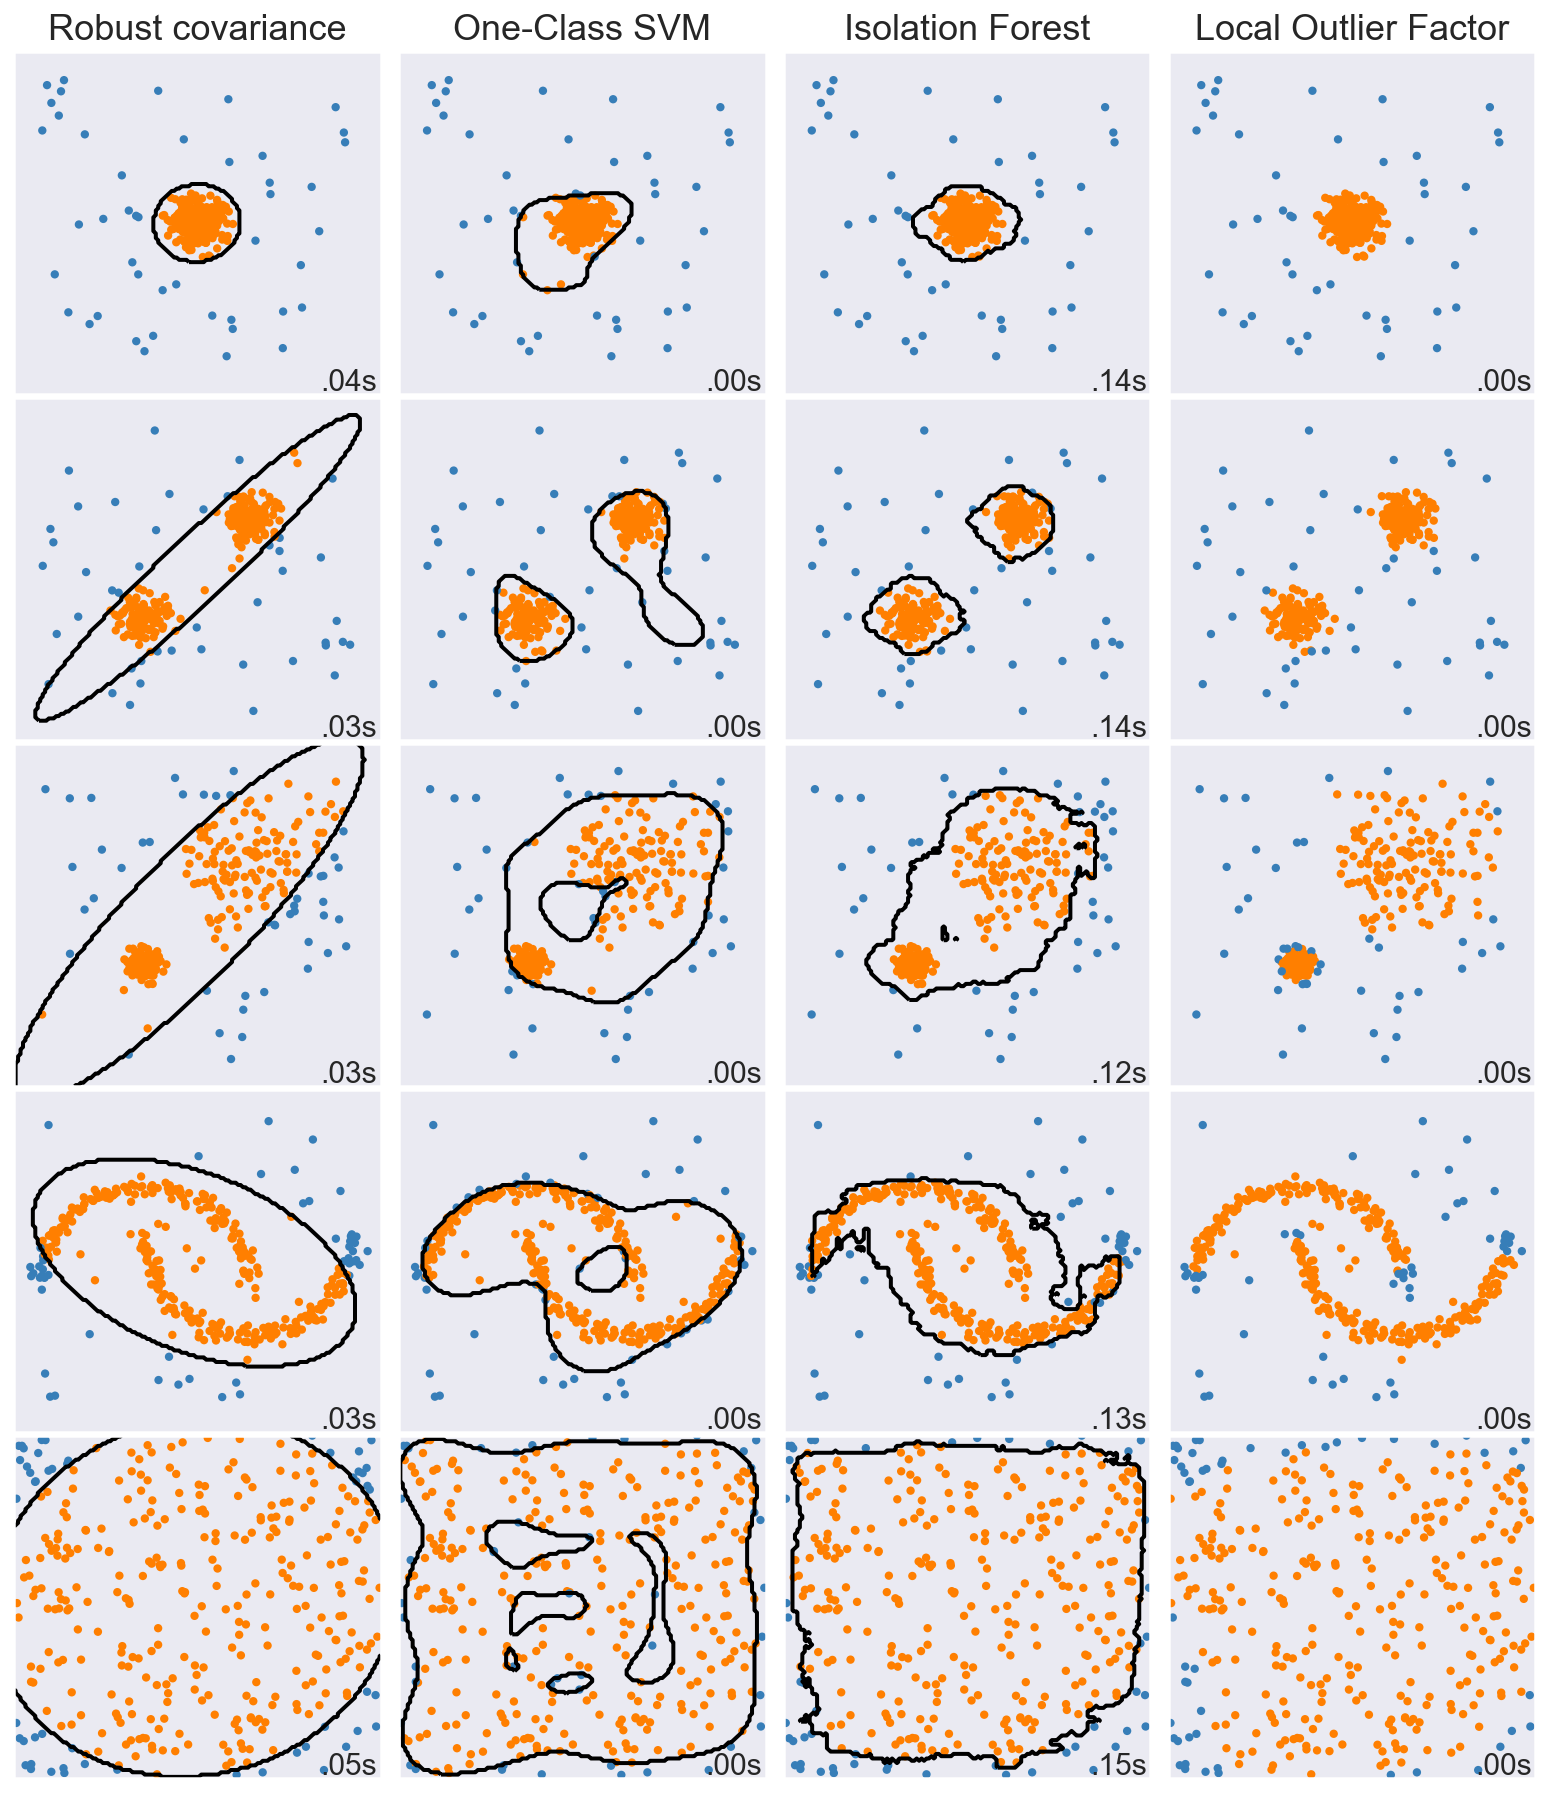

In [2]:
import time

import matplotlib

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

`ensemble.IsolationForest` and
`neighbors.LocalOutlierFactor` perform
reasonably well on the data sets considered here. The
`svm.OneClassSVM` is known to be
sensitive to outliers and thus does not perform very well for outlier
detection. Finally, `covariance.EllipticEnvelope`
 assumes the data is Gaussian and learns an ellipse. For
more details on the different estimators refer to the example
`sphx_glr_auto_examples_plot_anomaly_comparison.py` and the sections hereunder.


## Novelty Detection

Consider a data set of $n$ observations from the same distribution
described by $p$ features. Consider now that we add one more observation
to that data set. Is the new observation so different from the others
that we can doubt it is regular? (i.e. does it come from the same
distribution?) Or on the contrary, is it so similar to the other that we
cannot distinguish it from the original observations? This is the
question addressed by the novelty detection tools and methods.

In general, it is about to learn a rough, close frontier delimiting the
contour of the initial observations distribution, plotted in embedding
$p$-dimensional space. Then, if further observations lay within the
frontier-delimited subspace, they are considered as coming from the same
population than the initial observations. Otherwise, if they lay outside
the frontier, we can say that they are abnormal with a given confidence
in our assessment.

The One-Class SVM has been introduced by Schölkopf et al. for that
purpose and implemented in the `svm`
module in the `svm.OneClassSVM` object.
It requires the choice of a kernel and a scalar parameter to define a
frontier. The RBF kernel is usually chosen although there exists no
exact formula or algorithm to set its bandwidth parameter. This is the
default in the scikit-learn implementation. The $\nu$ parameter, also
known as the margin of the One-Class SVM, corresponds to the probability
of finding a new, but regular, observation outside the frontier.

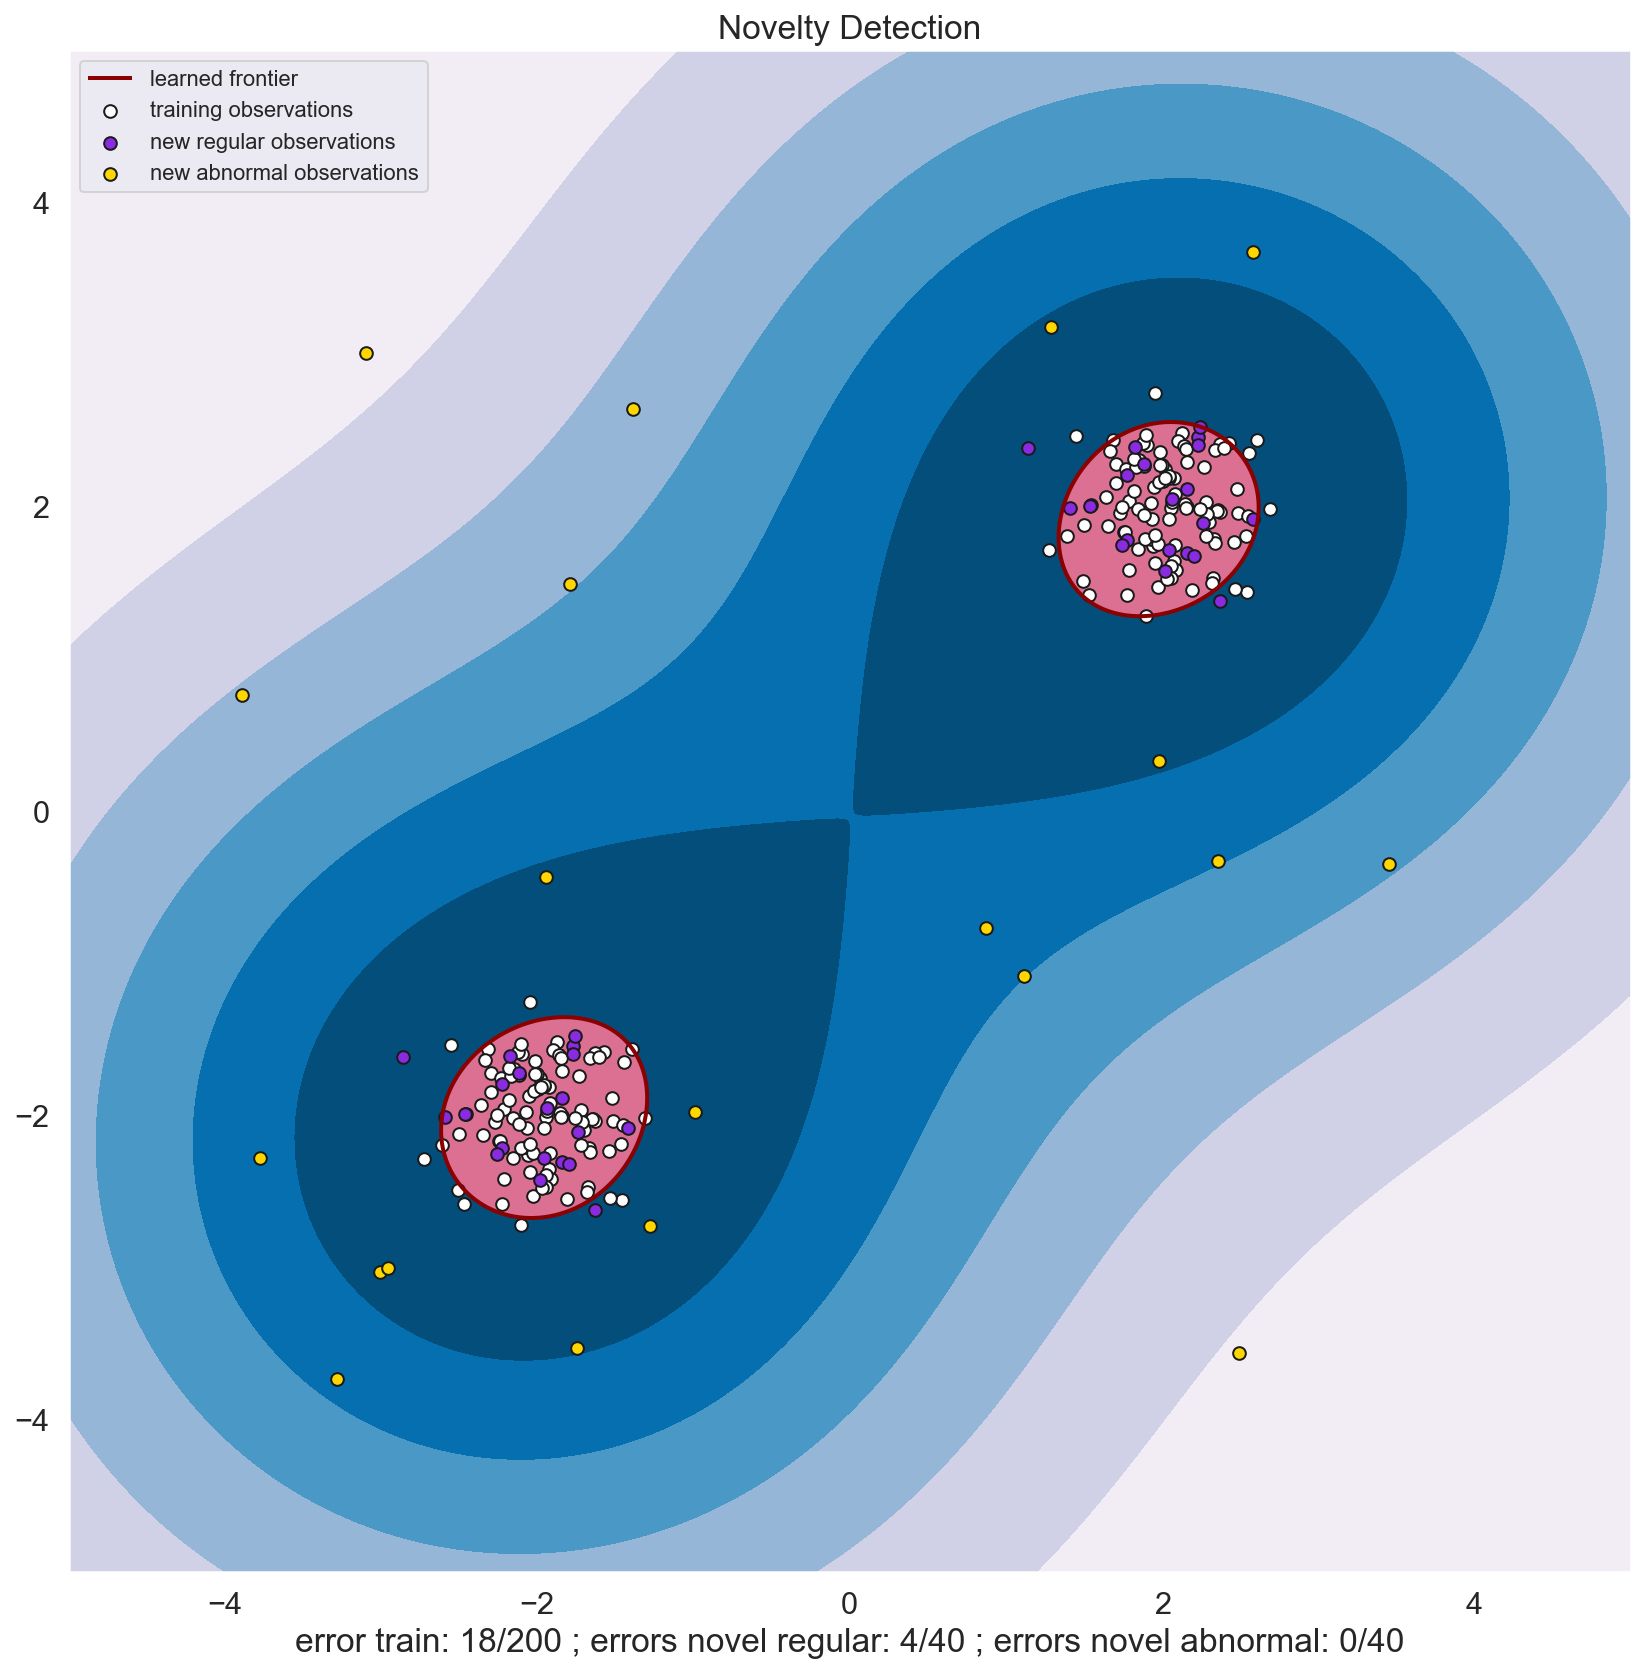

In [3]:
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


plt.figure(figsize=(14, 14))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

## Outlier Detection


Outlier detection is similar to novelty detection in the sense that the
goal is to separate a core of regular observations from some polluting
ones, called *outliers*. Yet, in the case of outlier detection, we
don\'t have a clean data set representing the population of regular
observations that can be used to train any tool.

### Fitting an elliptic envelope

One common way of performing outlier detection is to assume that the
regular data come from a known distribution (e.g. data are Gaussian
distributed). From this assumption, we generally try to define the
\"shape\" of the data, and can define outlying observations as
observations which stand far enough from the fit shape.

The scikit-learn provides an object
`covariance.EllipticEnvelope` that fits
a robust covariance estimate to the data, and thus fits an ellipse to
the central data points, ignoring points outside the central mode.

For instance, assuming that the inlier data are Gaussian distributed, it
will estimate the inlier location and covariance in a robust way (i.e.
without being influenced by outliers). The Mahalanobis distances
obtained from this estimate is used to derive a measure of outlyingness.
This strategy is illustrated below.

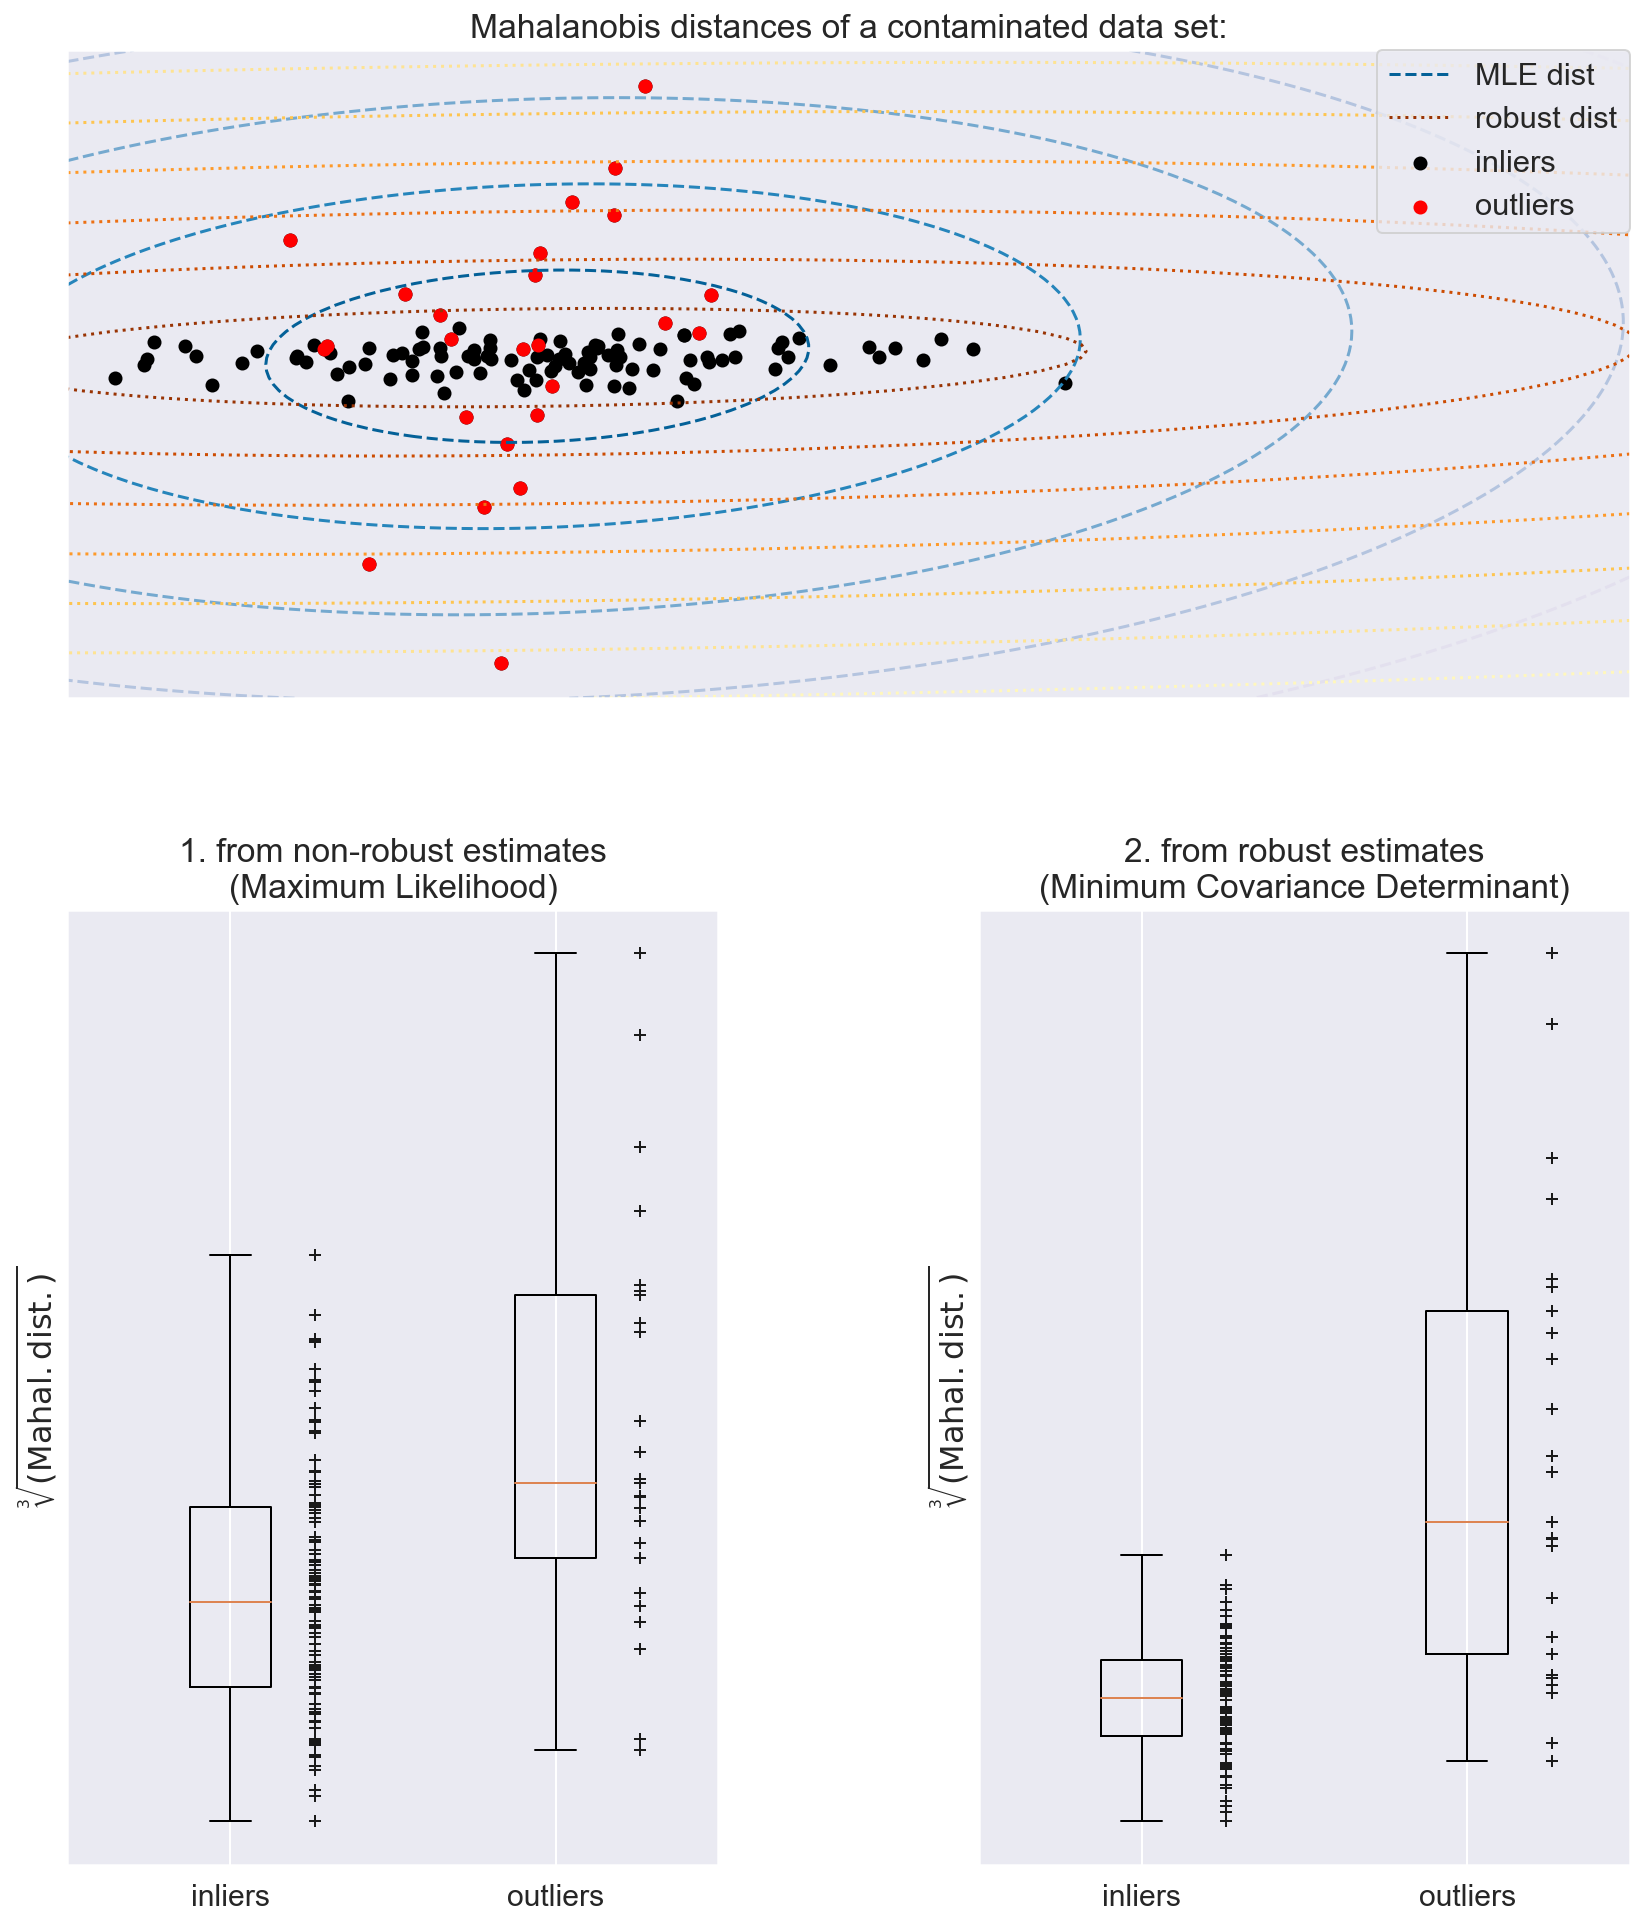

In [4]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

n_samples = 125
n_outliers = 25
n_features = 2

# generate data
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)
# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

# fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov = MinCovDet().fit(X)

# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(X)

# #############################################################################
# Display results
fig = plt.figure(figsize=(14, 14))
plt.subplots_adjust(hspace=-.1, wspace=.4, top=.95, bottom=.05)

# Show data set
subfig1 = plt.subplot(3, 1, 1)
inlier_plot = subfig1.scatter(X[:, 0], X[:, 1],
                              color='black', label='inliers')
outlier_plot = subfig1.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],
                               color='red', label='outliers')
subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title("Mahalanobis distances of a contaminated data set:")

# Show contours of the distance functions
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = subfig1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')

mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, linestyles='dotted')

subfig1.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
                inlier_plot, outlier_plot],
               ['MLE dist', 'robust dist', 'inliers', 'outliers'],
               loc="upper right", borderaxespad=0)
plt.xticks(())
plt.yticks(())

# Plot the scores for each point
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
subfig2 = plt.subplot(2, 2, 3)
subfig2.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
subfig2.plot(np.full(n_samples - n_outliers, 1.26),
             emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig2.plot(np.full(n_outliers, 2.26),
             emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig2.set_title("1. from non-robust estimates\n(Maximum Likelihood)")
plt.yticks(())

robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
subfig3 = plt.subplot(2, 2, 4)
subfig3.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
                widths=.25)
subfig3.plot(np.full(n_samples - n_outliers, 1.26),
             robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig3.plot(np.full(n_outliers, 2.26),
             robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig3.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig3.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig3.set_title("2. from robust estimates\n(Minimum Covariance Determinant)")
plt.yticks(())

plt.show()

### Isolation Forest

One efficient way of performing outlier detection in high-dimensional
datasets is to use random forests. The
`ensemble.IsolationForest` \'isolates\'
observations by randomly selecting a feature and then randomly selecting
a split value between the maximum and minimum values of the selected
feature.

Since recursive partitioning can be represented by a tree structure, the
number of splittings required to isolate a sample is equivalent to the
path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a
measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies.
Hence, when a forest of random trees collectively produce shorter path
lengths for particular samples, they are highly likely to be anomalies.

The implementation of `ensemble.IsolationForest`
 is based on an ensemble of
`tree.ExtraTreeRegressor`. Following
Isolation Forest original paper, the maximum depth of each tree is set
to $\lceil \log_2(n) \rceil$ where $n$ is the number of samples used to
build the tree (see (Liu et al., 2008) for more details).

This algorithm is illustrated below.

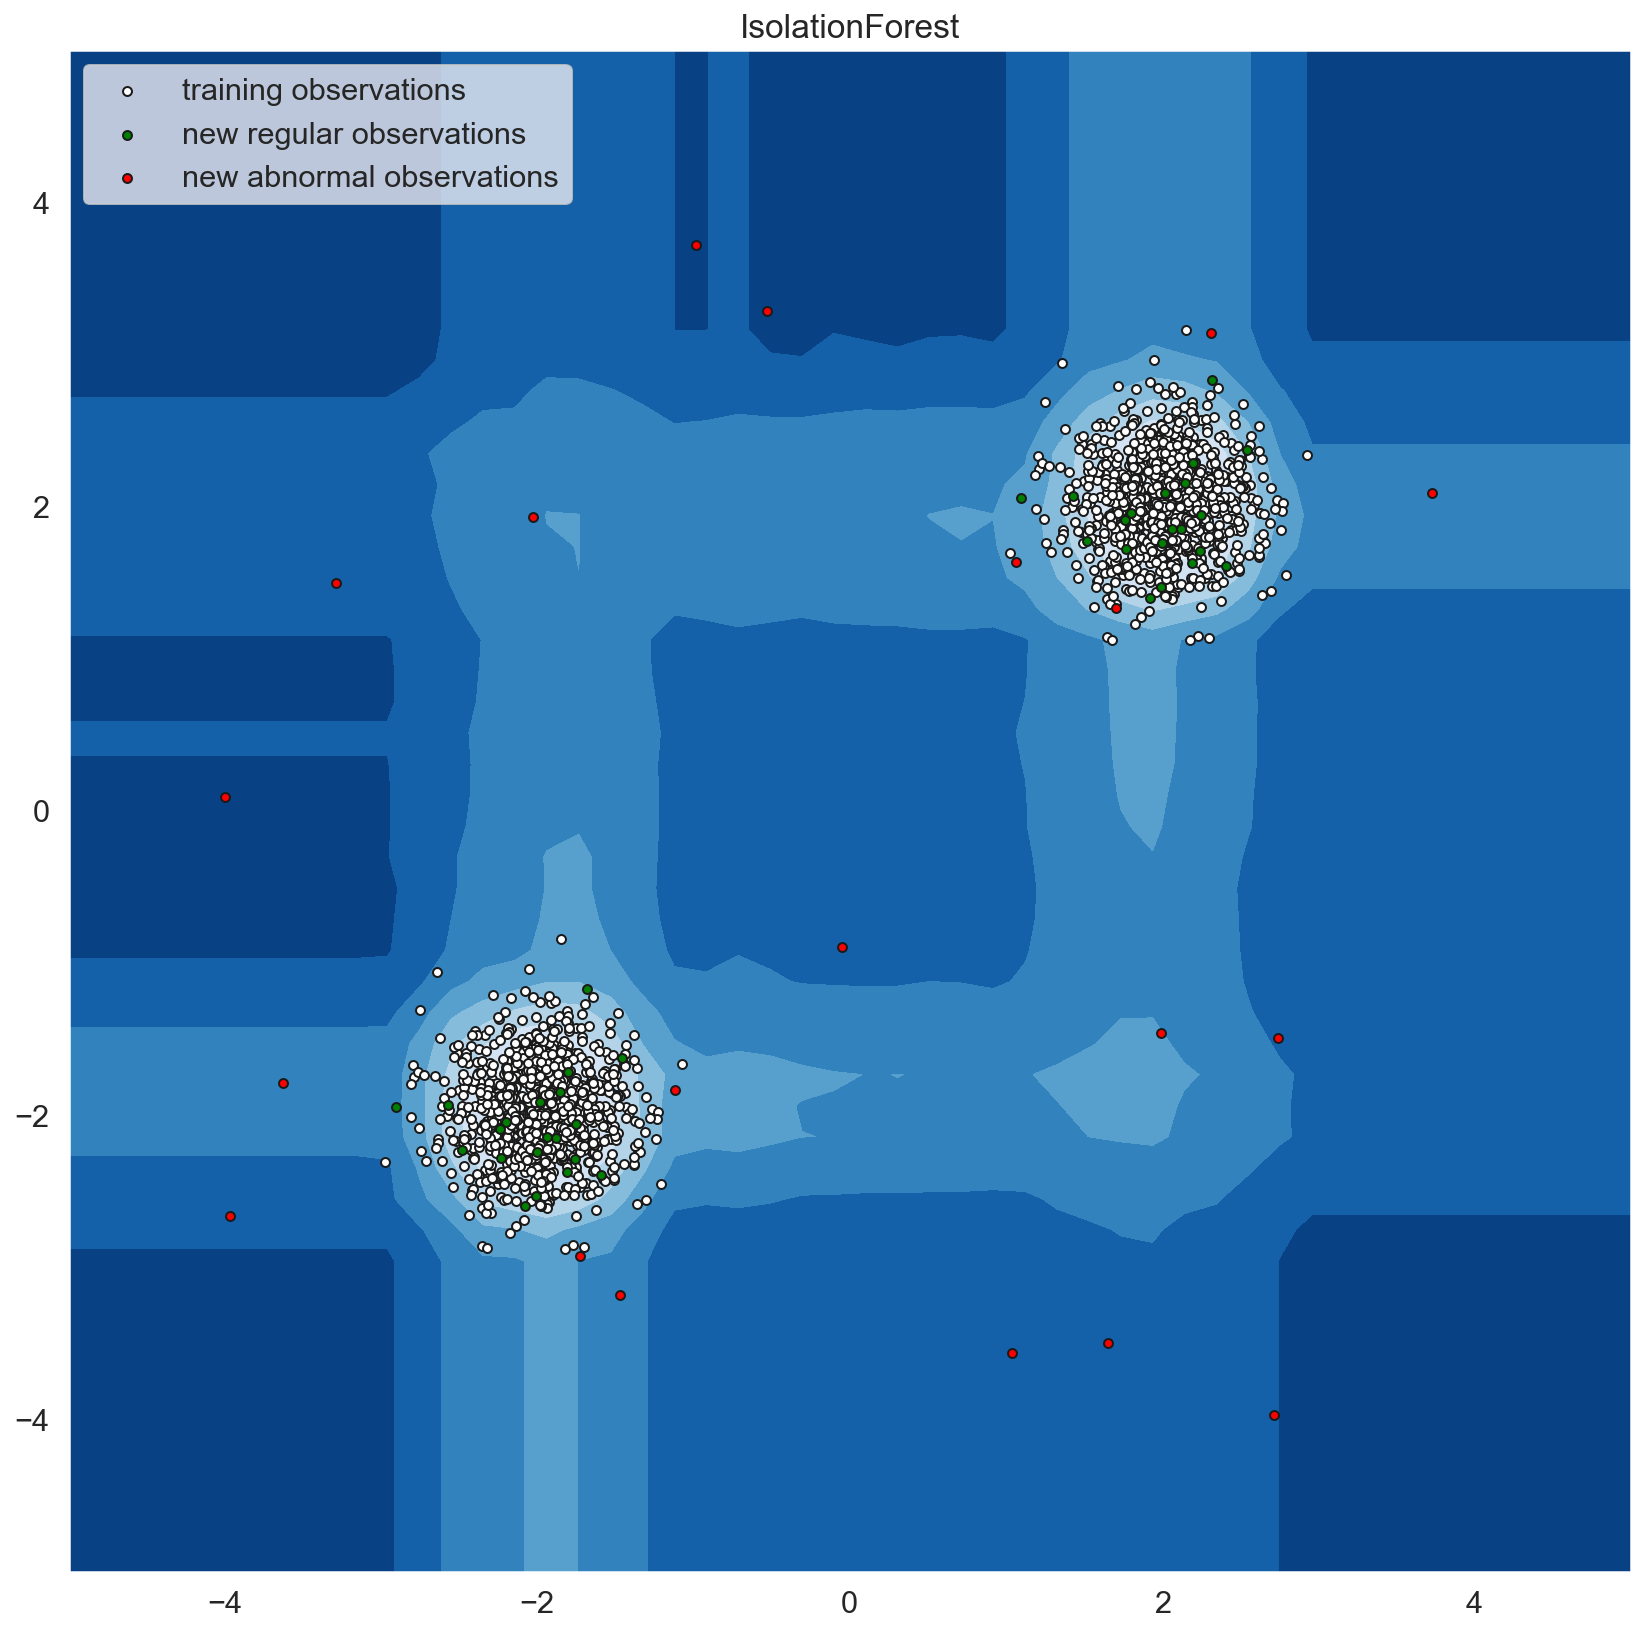

In [5]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(1000, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = IsolationForest(max_samples=1000, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# plot the line, the samples, and the nearest vectors to the plane
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(14, 14))
plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

### Local Outlier Factor

Another efficient way to perform outlier detection on moderately high
dimensional datasets is to use the Local Outlier Factor (LOF) algorithm.

The `neighbors.LocalOutlierFactor` (LOF)
algorithm computes a score (called local outlier factor) reflecting the
degree of abnormality of the observations. It measures the local density
deviation of a given data point with respect to its neighbors. The idea
is to detect the samples that have a substantially lower density than
their neighbors.

In practice the local density is obtained from the k-nearest neighbors.
The LOF score of an observation is equal to the ratio of the average
local density of his k-nearest neighbors, and its own local density: a
normal instance is expected to have a local density similar to that of
its neighbors, while abnormal data are expected to have much smaller
local density.

The number k of neighbors considered, (alias parameter n\_neighbors) is
typically chosen 1) greater than the minimum number of objects a cluster
has to contain, so that other objects can be local outliers relative to
this cluster, and 2) smaller than the maximum number of close by objects
that can potentially be local outliers. In practice, such information
are generally not available, and taking n\_neighbors=20 appears to work
well in general. When the proportion of outliers is high (i.e. greater
than 10 %, as in the example below), n\_neighbors should be greater
(n\_neighbors=35 in the example below).

The strength of the LOF algorithm is that it takes both local and global
properties of datasets into consideration: it can perform well even in
datasets where abnormal samples have different underlying densities. The
question is not, how isolated the sample is, but how isolated it is with
respect to the surrounding neighborhood.

When applying LOF for outlier detection, there are no `predict`,
`decision_function` and `score_samples` methods but only a `fit_predict`
method. The scores of abnormality of the training samples are accessible
through the `negative_outlier_factor_` attribute. Note that `predict`,
`decision_function` and `score_samples` can be used on new unseen data
when LOF is applied for novelty detection, i.e. when the `novelty`
parameter is set to `True`. See `novelty_with_lof`.

This strategy is illustrated below.

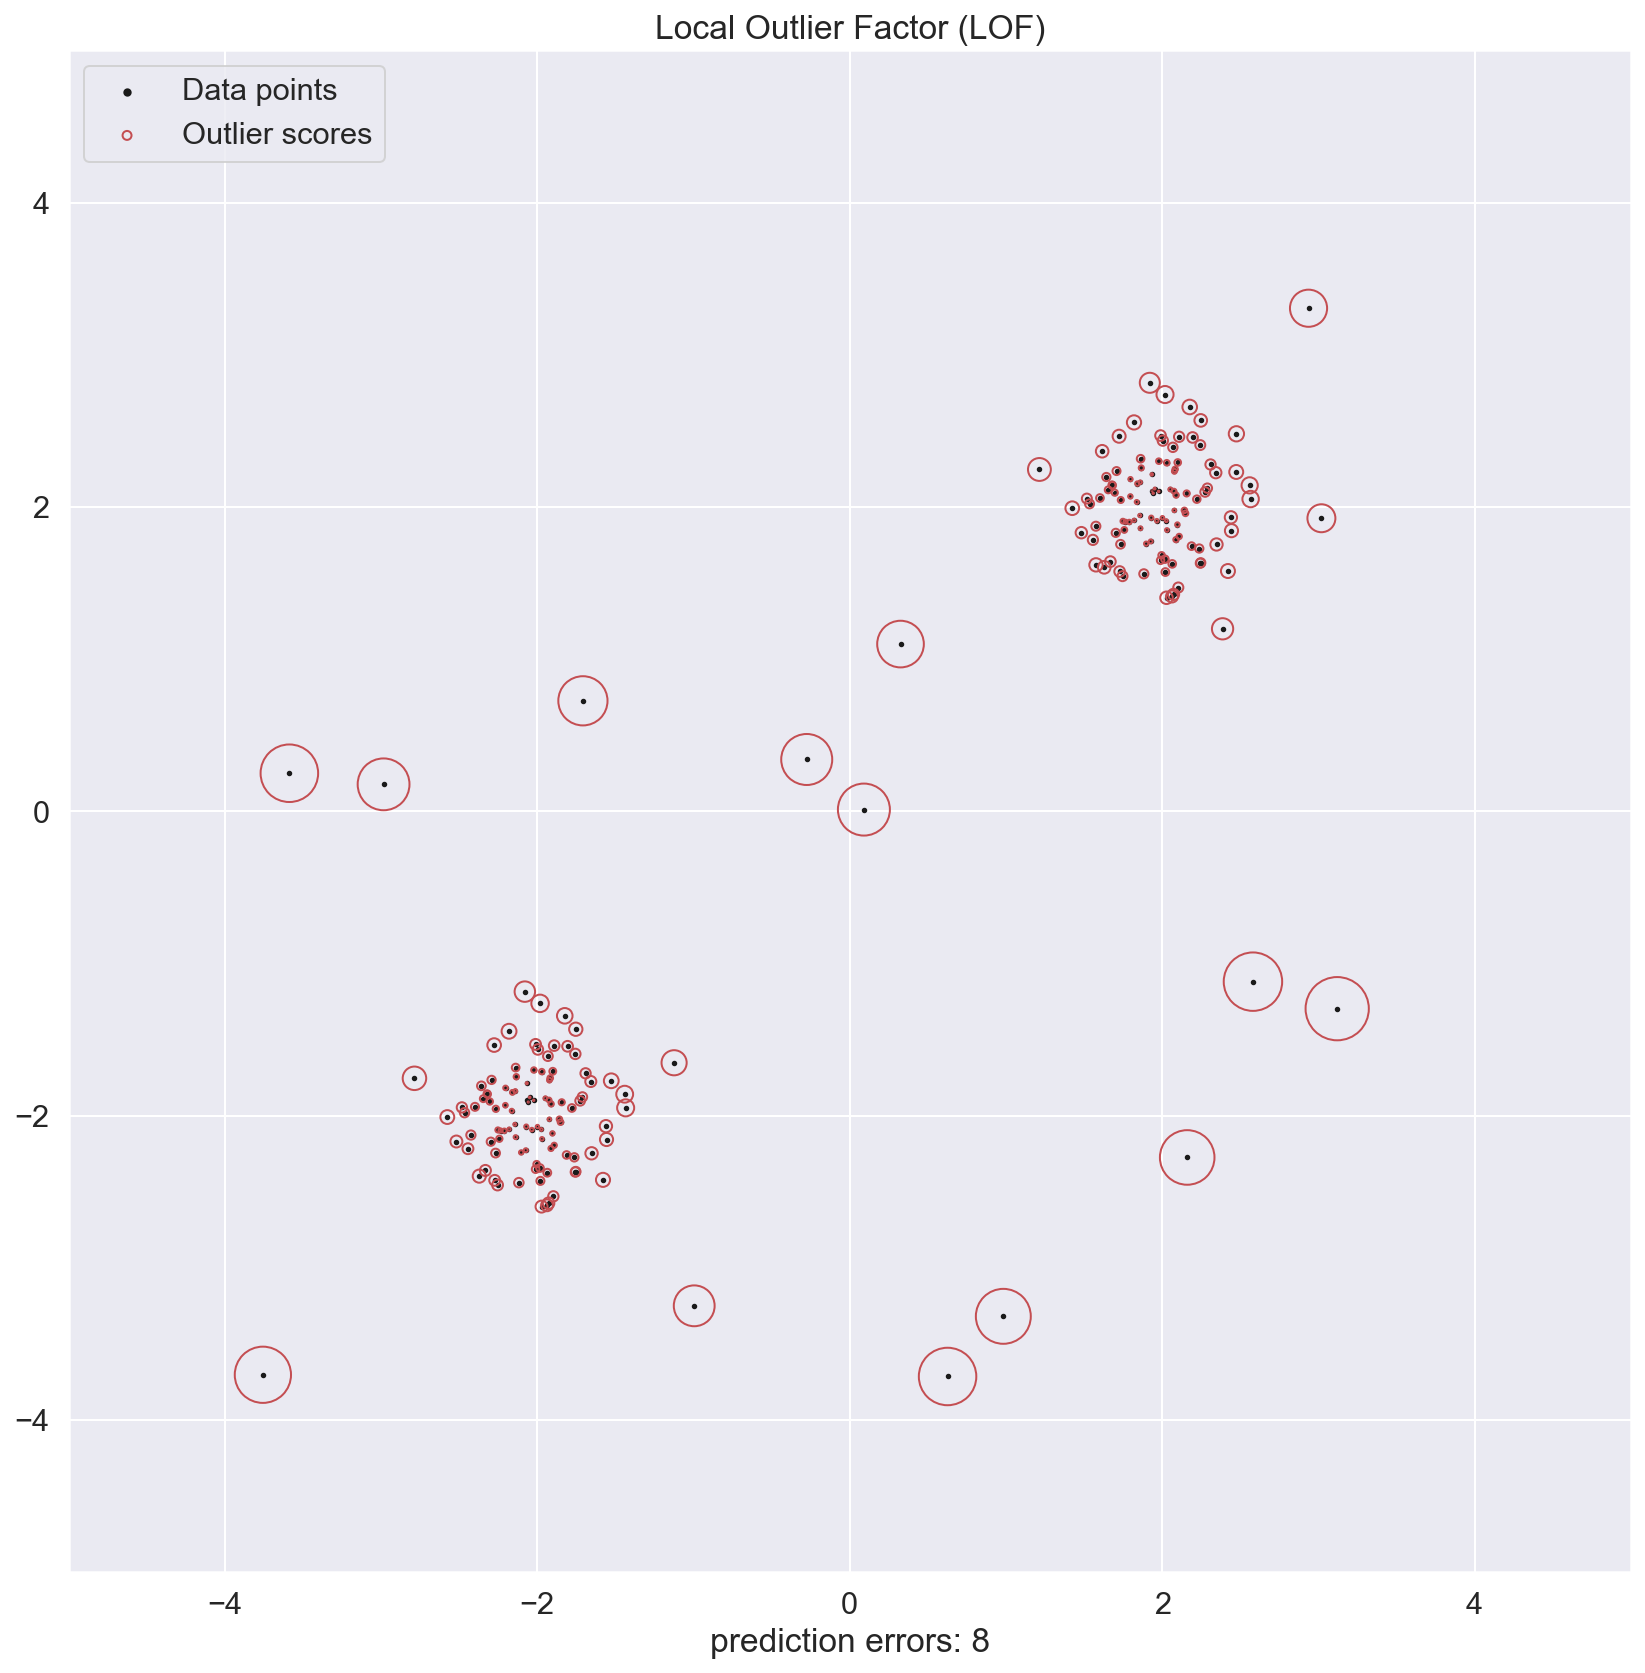

In [6]:
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.figure(figsize=(14, 14))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

### Novelty detection with Local Outlier Factor

To use `neighbors.LocalOutlierFactor`
for novelty detection, i.e. predict labels or compute the score of
abnormality of new unseen data, you need to instantiate the estimator
with the `novelty` parameter set to `True` before fitting the estimator:

>    lof = LocalOutlierFactor(novelty=True)
>    lof.fit(X_train)

Note that `fit_predict` is not available in this case.

**Novelty detection with Local Outlier Factor**

When `novelty` is set to `True` be aware that you must only use
`predict`, `decision_function` and `score_samples` on new unseen data
and not on the training samples as this would lead to wrong results. The
scores of abnormality of the training samples are always accessible
through the `negative_outlier_factor_` attribute.

Novelty detection with Local Outlier Factor is illustrated below.

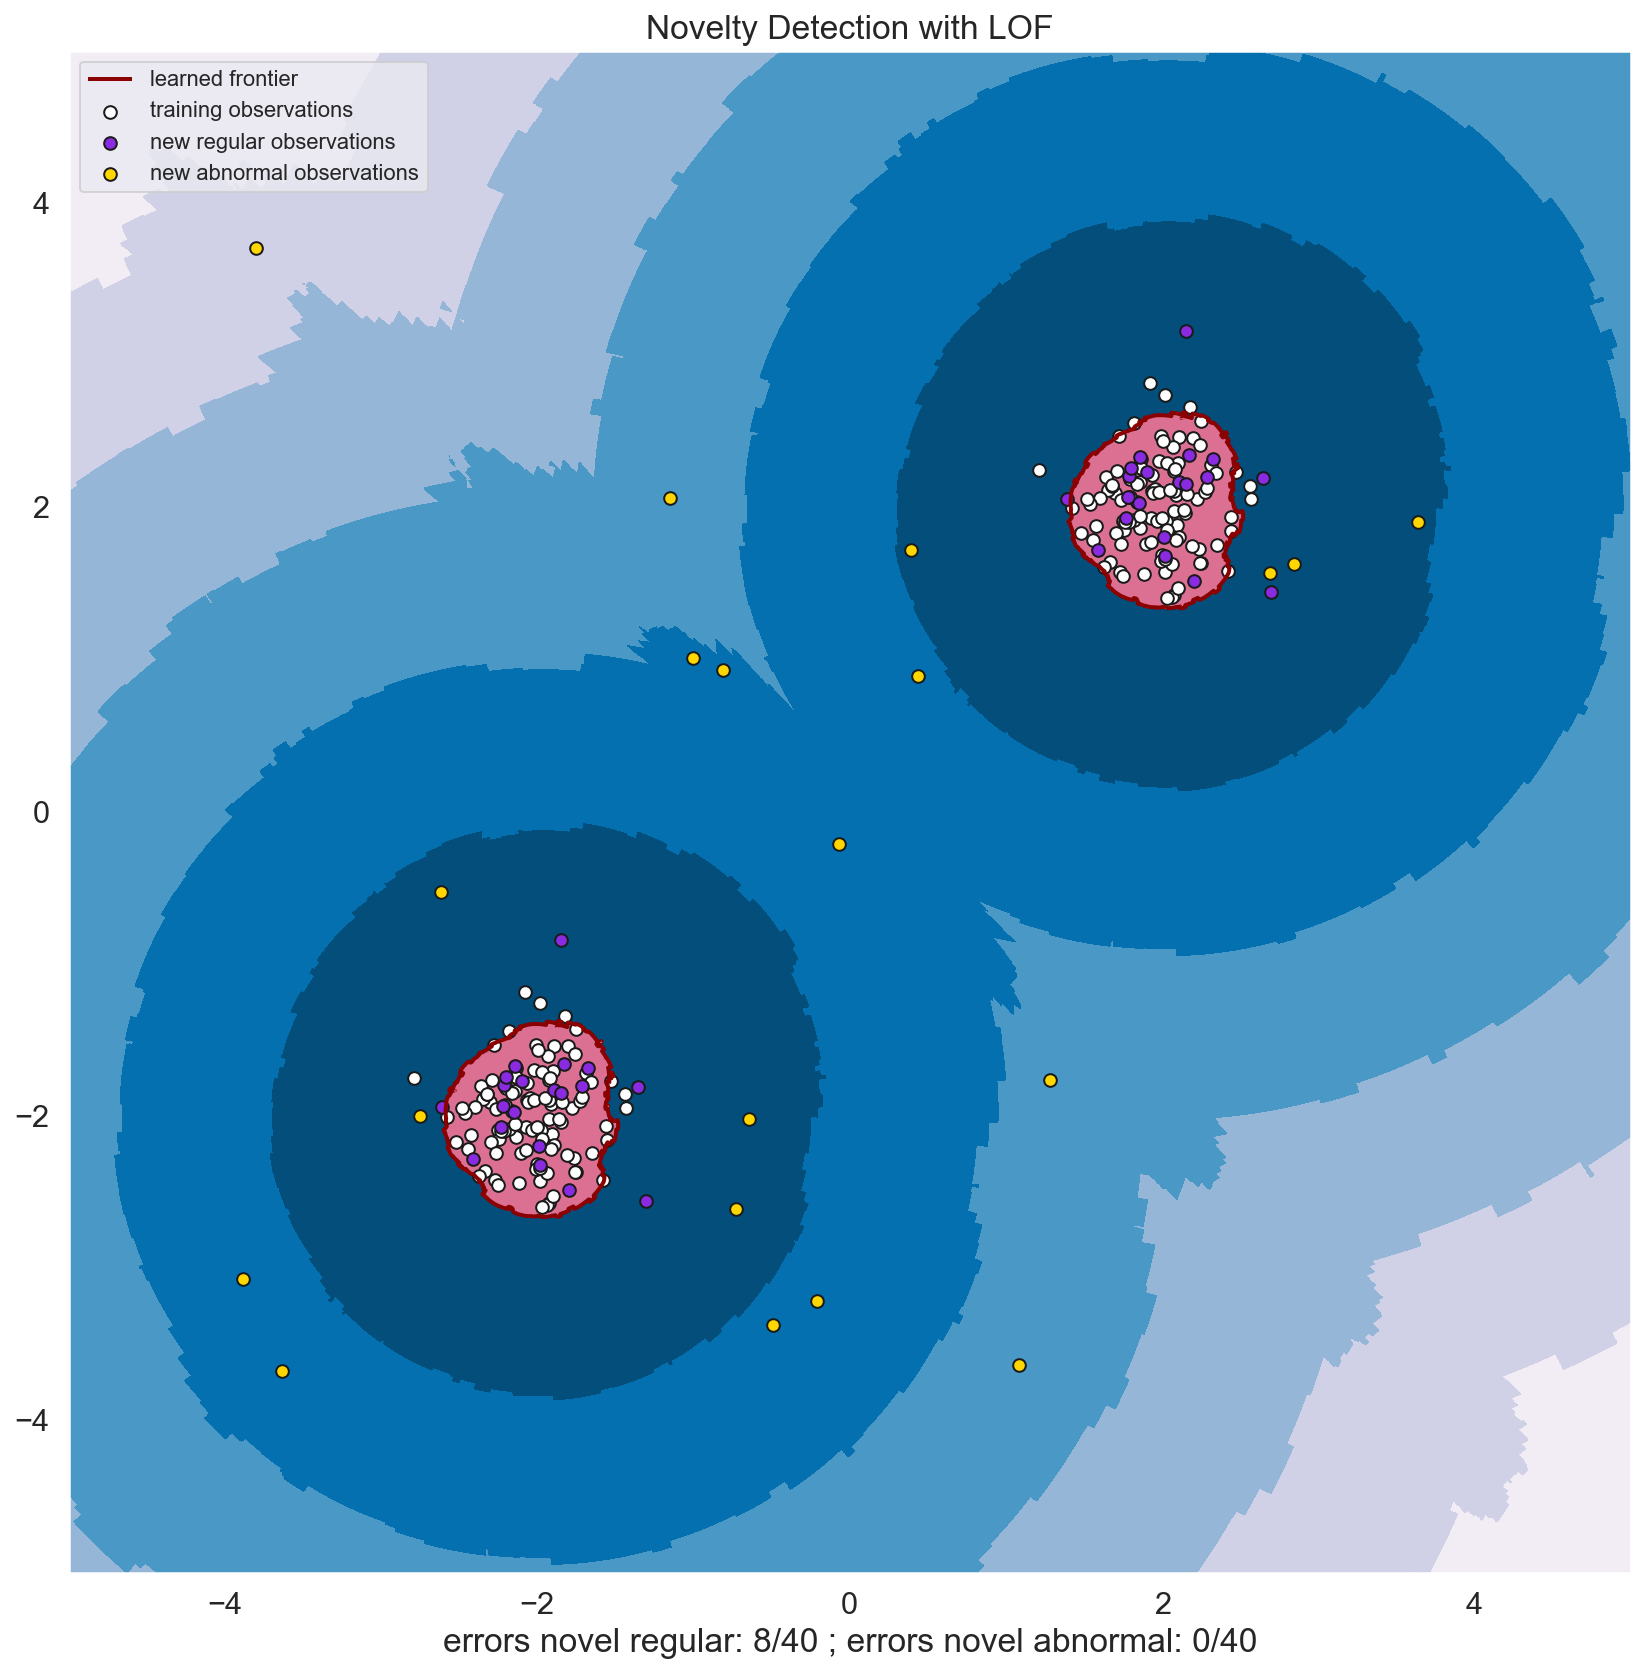

In [7]:
import matplotlib
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

xx, yy = np.meshgrid(np.linspace(-5, 5, 2000), np.linspace(-5, 5, 2000))
# Generate normal (not abnormal) training observations
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate new normal (not abnormal) observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model for novelty detection (novelty=True)
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)
# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the learned frontier, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(14, 14))
plt.title("Novelty Detection with LOF")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_test, n_error_outliers))
plt.show()

[[1](https://scikit-learn.org/stable/modules/outlier_detection.html)]